In [90]:
import os
import numpy as np 
import pandas as pd
import csv
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import	GridSearchCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir("/Users/seanmonahan/Documents/OneDrive/Documents/ISYE 4803/proj1")

#Read In Data
f = open("Heart.csv", 'r')
reader = csv.reader(f)
data = [r for r in reader]
f.close()

#Pick Column Vectors Decided
#data = [ [i[0], i[1], i[3], i[4], i[5], i[6], i[8], i[10], i[12], i[13], i[14]] for i in data ]

#Clean data:
head = data[0][1:]
data = data[1:]

#Convert values to float. If '?' then change to Null
ndata = []
for r in data:
	if int(r[-1]) == 0:
		ndata.append( [float(i) if i != "?" else None for i in r[1:] ])
	else:
		row = [float(i) if i != "?" else None for i in r[1:-1]]
		row.extend([1.0])
		ndata.append(row)

#Drop rows with Null in them
ndata = [i for i in ndata if None not in i]
colnames = ndata[0]
del ndata[0]
print(len(data) - len(ndata), "rows removed. Data has", len(ndata), "rows.")

#Scale Data
min_max_scaler = preprocessing.MinMaxScaler()
scale_data = min_max_scaler.fit_transform( np.array(ndata))

#define train data, x, y
x_train = [i[:-1] for i in scale_data[:25]]
x_data = [i[:-1] for i in scale_data]
y_train = [i[-1] for i in scale_data[:25]]
print(y_train, len(y_train), len(x_train))

7 rows removed. Data has 296 rows.
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0] 25 25


In [83]:
#Tune C and Gamma
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit( y_train, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(x_train, y_train)
print("The best parameters are {} with a score of {}".format(grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.0} with a score of 0.8


In [84]:
#Greedy Sequential Backwards Selection
cur_features = head[:-1]
j = len(cur_features)
greedy_plot_output = []
g_data = x_data[:]
max_acc = 0

while j > 1:
	print(j)
	feat_acc = []

	#Loop through the Current Features
	print(cur_features)
	for f in cur_features:
		
		#If we only have one current feature, append 0 to total accuracy and stop
		if len(cur_features) == 1:
			feat_acc.append( (f, 0) )
			break

		#Get an index that matches the current feature, f
		m_index = 0
		for obj in cur_features:
			if f == obj:
				break
			else:
				m_index += 1

		#print("match index is:", m_index)
		#Drop Data not associated with current features
		tmp_data = []
		tmp_x_train = []
		counter = 0
		for i in g_data:
			if m_index < (len(i) - 1):
				row = i[:m_index]
				row = np.append(arr=row, values=i[m_index + 1:]) 
			else:
				row = i[:m_index]
			tmp_data.append(row)
			#Add to training data set, but only for 25 records
			if counter < 25:
				tmp_x_train.append(row)
			counter += 1


		#Run model with new subsetted dataset
		mod = svm.SVC(kernel='linear', C = grid.best_params_["C"])
		mod.fit(tmp_x_train, y_train)
		greedy_out = mod.predict(tmp_data)

		# Append results to original data for comparison. Allows to compute accuracy
		comp_data = []
		i = 0
		for c in range(len(greedy_out)):
			row = list(ndata[i])
			row.append(greedy_out[c])
			comp_data.append(row)
			i += 1
		
		#Compute Accuracy Statistic
		match = 0
		for i in range(len(comp_data[1:])):
			if comp_data[i][-2] == comp_data[i][-1]:
				match += 1
		acc = match / len(greedy_out)

		#Append Accuracy Statistic and Feature Name to list. Use this to determine which to drop.
		feat_acc.append( ( f, acc) )

	#Figure out which dropped feature had the model with the highest accuracy:
	max_lower_acc = list(filter(lambda x: x[1] == max( [y[1] for y in feat_acc]), feat_acc ))
	print("Feature Dropped from Current Features:", max_lower_acc)
	greedy_plot_output.append([j,max_lower_acc[0][1]])
	

	#Drop that column from the set
	new_cur_features = [q for q in cur_features if q != max_lower_acc[0][0]]
	feat_ind = 0
	k = 0
	while k < len(cur_features):
		if cur_features[k] != new_cur_features[k]:
			feat_ind = k 
			#print(cur_features[:k+1],"\n", new_cur_features[:k+1], "\nThe index is:", feat_ind)
			break
		k += 1
	cur_features = new_cur_features[:]
	#print("Match Index is:", feat_ind)

	#Drop that column from g_data
	tmp_data = g_data[:]
	k = 0
	for r in tmp_data:
		if feat_ind != (len(r) - 1):
			row = r[:feat_ind]
			row = np.append(row, r[feat_ind+1:])
		else:
			row = r[:feat_ind]
		tmp_data[k] = row
		k += 1

	g_data = tmp_data[:]

	#If model has better accuracy than previous (and less features), save the data for future use
	if max_lower_acc[0][1] >= max_acc:
		print("Iteration", j, "resulted in new max:", max_lower_acc[0][1])
		max_acc = max_lower_acc[0][1]
		final_x_data = g_data[:]
		final_x_train = g_data[:25]
		saved_features = new_cur_features[:]

	#Loop again.
	j -= 1

print(greedy_plot_output)



13
['Age', 'Sex', 'CP', 'Trestbps', 'Chol', 'Fbs', 'Restecg', 'Thalach', 'Exang', 'Oldpeak', 'Slope', 'Ca', 'Thal']
Feature Dropped from Current Features: [('Restecg', 0.8277027027027027)]
Iteration 13 resulted in new max: 0.8277027027027027
12
['Age', 'Sex', 'CP', 'Trestbps', 'Chol', 'Fbs', 'Thalach', 'Exang', 'Oldpeak', 'Slope', 'Ca', 'Thal']
Feature Dropped from Current Features: [('Age', 0.8344594594594594), ('Trestbps', 0.8344594594594594)]
Iteration 12 resulted in new max: 0.8344594594594594
11
['Sex', 'CP', 'Trestbps', 'Chol', 'Fbs', 'Thalach', 'Exang', 'Oldpeak', 'Slope', 'Ca', 'Thal']
Feature Dropped from Current Features: [('Trestbps', 0.8412162162162162), ('Fbs', 0.8412162162162162)]
Iteration 11 resulted in new max: 0.8412162162162162
10
['Sex', 'CP', 'Chol', 'Fbs', 'Thalach', 'Exang', 'Oldpeak', 'Slope', 'Ca', 'Thal']
Feature Dropped from Current Features: [('Sex', 0.8445945945945946)]
Iteration 10 resulted in new max: 0.8445945945945946
9
['CP', 'Chol', 'Fbs', 'Thalach', 

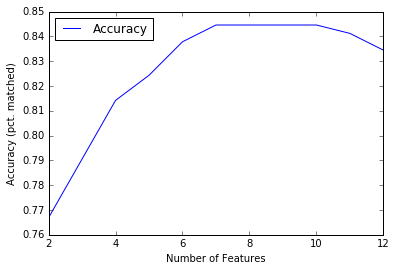

In [85]:
#Plot Results of Greedy Selection Process
plot_df = pd.DataFrame(greedy_plot_output, columns=["K", "Accuracy"])
plot_df.set_index("K", inplace=True)
plot_df = plot_df.reindex([i for i in range(2,13)])
plot_df.plot()
plt.xlabel("Number of Features")
plt.ylabel("Accuracy (pct. matched)")

In [86]:
#Fit Best Model from Greedy Selection
print("From Greedy, using features:", saved_features)
clf = svm.SVC(kernel='linear', C = grid.best_params_["C"])
clf.fit(final_x_train, y_train)
sv_out = clf.predict(final_x_data)

#Create Output File
head.append("Pred_Out")
sv_out_data = [head[:]]
i = 0
for c in range(len(sv_out)):
	row = list(ndata[i])
	row.append(sv_out[c])
	sv_out_data.append(row)
	i += 1

#Compute Accuracy metric
match = 0
for i in range(len(sv_out_data[1:])):
	if sv_out_data[i][-2] == sv_out_data[i][-1]:
		match += 1
print("Pct. Match", float(match/len(sv_out_data)))

#Write File
f = open("sv_output.csv", 'w', newline="")
writer = csv.writer(f)
writer.writerows(sv_out_data)
f.close()


From Greedy, using features: ['CP', 'Chol', 'Exang', 'Slope', 'Ca', 'Thal']
Pct. Match 0.8417508417508418


Sensitivity: 0.7883211678832117
Specificity: 0.8930817610062893


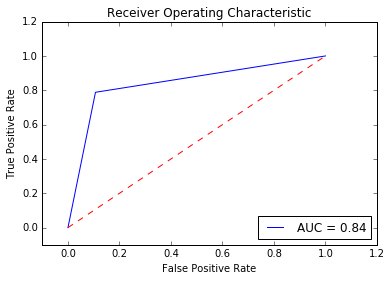

25 25


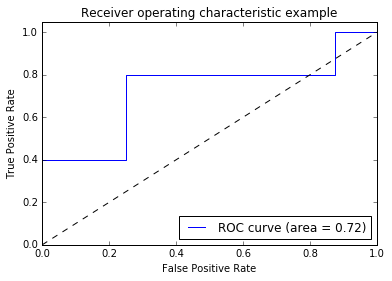

In [91]:
# Calculate Sensitivity, Specificity, and ROC Curve
tp = 0
tn = 0
fp = 0
fn = 0
for row in sv_out_data[1:]:
    if (row[-2] == 1) and (row[-1] == 1): #True Positive
        tp += 1
    if (row[-2] == 1) and (row[-1] == 0): #False Negative
        fn += 1
    if (row[-2] == 0) and (row[-1] == 1): #False Positive
        fp += 1
    if (row[-2] == 0) and (row[-1] == 0): #False Negative
        tn += 1
        
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

#For ROC curve, need to change cutoff points and recompute spec and sens??
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
actual = np.array([ i[-2] for i in sv_out_data[1:]])
predictions = np.array([ i[-1] for i in sv_out_data[1:]])

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

X = np.array(final_x_train)
y = np.array(y_train)
print(len(X), len(y))


# Binarize the output
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


##############################################################################
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
